In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
# !pip install sklearn_crfsuite

In [2]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

## Let's use CoNLL 2002 data to build a NER system

CoNLL2002 corpus is available in NLTK. We use Spanish data.

In [3]:
nltk.corpus.conll2002.fileids()

['esp.testa', 'esp.testb', 'esp.train', 'ned.testa', 'ned.testb', 'ned.train']

In [4]:
%%time
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))

CPU times: total: 5.39 s
Wall time: 6.65 s


In [5]:
train_sents[0]

[('Melbourne', 'NP', 'B-LOC'),
 ('(', 'Fpa', 'O'),
 ('Australia', 'NP', 'B-LOC'),
 (')', 'Fpt', 'O'),
 (',', 'Fc', 'O'),
 ('25', 'Z', 'O'),
 ('may', 'NC', 'O'),
 ('(', 'Fpa', 'O'),
 ('EFE', 'NC', 'B-ORG'),
 (')', 'Fpt', 'O'),
 ('.', 'Fp', 'O')]

## Features

Next, define some features. In this example we use word identity, word suffix, word shape and word POS tag; also, some information from nearby words is used. 

This makes a simple baseline, but you certainly can add and remove some features to get (much?) better results - experiment with it.

sklearn-crfsuite (and python-crfsuite) supports several feature formats; here we use feature dicts.

In [6]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],        
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
                
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

This is what word2features extracts:

In [7]:
sent2features(train_sents[0])[0]

{'bias': 1.0,
 'word.lower()': 'melbourne',
 'word[-3:]': 'rne',
 'word[-2:]': 'ne',
 'word.isupper()': False,
 'word.istitle()': True,
 'word.isdigit()': False,
 'postag': 'NP',
 'postag[:2]': 'NP',
 'BOS': True,
 '+1:word.lower()': '(',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:postag': 'Fpa',
 '+1:postag[:2]': 'Fp'}

Extract features from the data:

In [8]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

CPU times: total: 2.78 s
Wall time: 3.43 s


In [12]:
y_train[0][0]

'B-LOC'

## Training

To see all possible CRF parameters check its docstring. Here we are useing L-BFGS training algorithm (it is default) with Elastic Net (L1 + L2) regularization.

In [14]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: total: 1min 18s
Wall time: 1min 19s


AttributeError: 'CRF' object has no attribute 'keep_tempfiles'

AttributeError: 'CRF' object has no attribute 'keep_tempfiles'

AttributeError: 'CRF' object has no attribute 'keep_tempfiles'

## Evaluation

There is much more O entities in data set, but we're more interested in other entities. To account for this we'll use averaged F1 score computed for all labels except for O. ``sklearn-crfsuite.metrics`` package provides some useful metrics for sequence classification task, including this one.

In [25]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-LOC', 'B-ORG', 'B-PER', 'I-PER', 'B-MISC', 'I-ORG', 'I-LOC', 'I-MISC']

In [26]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

0.76980231377134023

Inspect per-class results in more detail:

In [27]:
# group B and I results
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

      B-LOC      0.775     0.757     0.766      1084
      I-LOC      0.601     0.631     0.616       325
     B-MISC      0.698     0.499     0.582       339
     I-MISC      0.644     0.567     0.603       557
      B-ORG      0.795     0.801     0.798      1400
      I-ORG      0.831     0.773     0.801      1104
      B-PER      0.812     0.876     0.843       735
      I-PER      0.873     0.931     0.901       634

avg / total      0.779     0.764     0.770      6178



## Hyperparameter Optimization

To improve quality try to select regularization parameters using randomized search and 3-fold cross-validation.

I takes quite a lot of CPU time and RAM (we're fitting a model ``50 * 3 = 150`` times), so grab a tea and be patient, or reduce n_iter in RandomizedSearchCV, or fit model only on a subset of training data.

In [28]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space, 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1, 
                        n_iter=50, 
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 16.1min finished


CPU times: user 3min 34s, sys: 13.9 s, total: 3min 48s
Wall time: 16min 36s


Best result:

In [36]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c2': 0.06146442424219609, 'c1': 0.30343585910230675}
best CV score: 0.748852160441
model size: 1.08M


### Check parameter space

A chart which shows which ``c1`` and ``c2`` values have RandomizedSearchCV checked. Red color means better results, blue means worse.

Dark blue => 0.7013, dark red => 0.7489


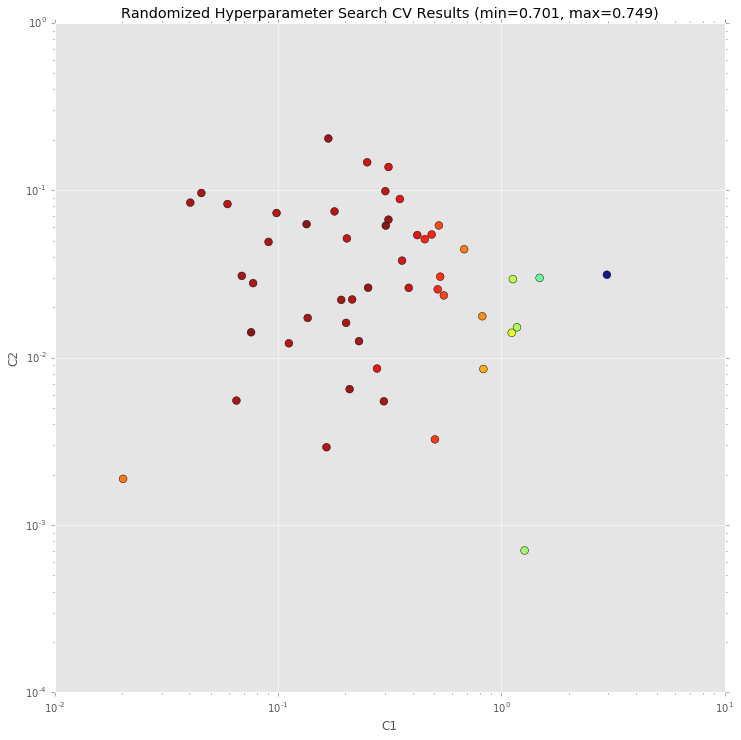

In [39]:
_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

## Check best estimator on our test data

As you can see, quality is improved.

In [45]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

      B-LOC      0.800     0.780     0.790      1084
      I-LOC      0.663     0.625     0.643       325
     B-MISC      0.729     0.555     0.630       339
     I-MISC      0.709     0.582     0.639       557
      B-ORG      0.808     0.824     0.816      1400
      I-ORG      0.849     0.783     0.814      1104
      B-PER      0.836     0.882     0.858       735
      I-PER      0.884     0.942     0.912       634

avg / total      0.804     0.781     0.791      6178



## Let's check what classifier learned

In [47]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
B-ORG  -> I-ORG   7.029925
I-ORG  -> I-ORG   6.672091
B-MISC -> I-MISC  6.450077
I-MISC -> I-MISC  6.420227
B-PER  -> I-PER   5.898448
B-LOC  -> I-LOC   5.293131
I-LOC  -> I-LOC   4.669233
I-PER  -> I-PER   4.327948
O      -> O       3.773498
O      -> B-ORG   2.723333
O      -> B-PER   2.298990
O      -> B-LOC   1.753950
O      -> B-MISC  1.608865
B-ORG  -> O       0.373792
B-LOC  -> B-LOC   0.363950
B-MISC -> B-ORG   0.213808
B-ORG  -> B-LOC   0.122352
I-PER  -> B-LOC   0.055117
B-LOC  -> B-PER   -0.141696
B-MISC -> O       -0.170980

Top unlikely transitions:
I-ORG  -> B-LOC   -2.281004
I-LOC  -> I-PER   -2.285589
I-MISC -> B-LOC   -2.286738
I-LOC  -> B-MISC  -2.299090
B-LOC  -> B-MISC  -2.312090
I-ORG  -> I-PER   -2.636941
I-ORG  -> B-MISC  -2.673906
B-ORG  -> B-MISC  -2.735029
I-PER  -> B-ORG   -2.822961
B-PER  -> B-MISC  -2.857271
I-MISC -> I-LOC   -2.902497
I-PER  -> I-LOC   -2.931078
I-ORG  -> I-LOC   -2.943800
B-PER  -> B-PER   -3.063315
I-PER  -> B-MIS

We can see that, for example, it is very likely that the beginning of an organization name (B-ORG) will be followed by a token inside organization name (I-ORG), but transitions to I-ORG from tokens with other labels are penalized.

Check the state features:

In [55]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))    

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
11.005266 B-ORG    word.lower():efe-cantabria
9.385823 B-ORG    word.lower():psoe-progresistas
6.715219 I-ORG    -1:word.lower():l
5.638921 O        BOS
5.378117 B-LOC    -1:word.lower():cantabria
5.302705 B-ORG    word.lower():xfera
5.287491 B-ORG    word[-2:]:-e
5.239806 B-ORG    word.lower():petrobras
5.214013 B-MISC   word.lower():diversia
5.025534 B-ORG    word.lower():coag-extremadura
5.020590 B-ORG    word.lower():telefónica
4.804399 B-MISC   word.lower():justicia
4.729711 B-MISC   word.lower():competencia
4.705013 O        postag[:2]:Fp
4.695208 B-ORG    -1:word.lower():distancia
4.681021 I-ORG    -1:word.lower():rasd
4.636151 I-LOC    -1:word.lower():calle
4.618459 B-ORG    word.lower():terra
4.580418 B-PER    -1:word.lower():según
4.574348 B-ORG    word.lower():esquerra
4.537127 O        word.lower():r.
4.537127 O        word[-3:]:R.
4.536578 B-MISC   word.lower():cc2305001730
4.510408 B-ORG    +1:word.lower():plasencia
4.471889 B-LOC    +1:word.lower():finaliza



Some observations:

   * **9.385823 B-ORG word.lower():psoe-progresistas** - the model remembered names of some entities - maybe it is overfit, or maybe our features are not adequate, or maybe remembering is indeed helpful;
   * **4.636151 I-LOC -1:word.lower():calle:** "calle" is a street in Spanish; model learns that if a previous word was "calle" then the token is likely a part of location;
   * **-5.632036 O word.isupper()**, **-8.215073 O word.istitle()** : UPPERCASED or TitleCased words are likely entities of some kind;
   * **-2.097561 O postag:NP** - proper nouns (NP is a proper noun in the Spanish tagset) are often entities.

What to do next

    * Load 'testa' Spanish data.
    * Use it to develop better features and to find best model parameters.
    * Apply the model to 'testb' data again.

The model in this notebook is just a starting point; you certainly can do better!

